In [19]:
import re
import cohere
import requests

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from lxml import html
from bs4 import BeautifulSoup
from unidecode import unidecode

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.preprocessing import LabelEncoder

In [20]:
artist = "hollow coves"
API_KEY = ""

In [21]:
class Discography:
    def __init__(self, artist, albums, verbose=True):
        self.verbose = verbose
        self.artist = artist
        self.albums = albums
        self.num_albums = len(albums)
        self.co = cohere.Client(API_KEY)
        self.df = self.get_df()

    def get_df(self) -> pd.DataFrame:
        """Get pandas dataframe from albums - each row is a song
        
        Returns:
            pd.DataFrame -- dataframe with columns: artist, album, song_title, lyrics, url, lyrics_embedding
        """
        if self.verbose:
            print(f"Getting dataframe for {self.artist}...")

        df = pd.DataFrame()
        for album in self.albums:
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "artist": self.artist,
                            "album": album.title,
                            "song_title": [song.title for song in album.songs],
                            "lyrics": [song.lyrics for song in album.songs],
                            "url": [song.url for song in album.songs],
                        }
                    ),
                ]
            )

        df = df.reset_index(drop=True)
        df = self.get_embeddings(df, "lyrics")
        df = self.get_embeddings(df, "song_title")

        return df

    def get_embeddings(self, df: pd.DataFrame, column: str) -> pd.DataFrame:
        """Get embeddings for a column
        
        Args:
            df (pd.DataFrame): dataframe
            column (str): column to get embeddings for

        Returns:
            pd.DataFrame -- dataframe with column: {column}_embedding
        """

        if self.verbose:
            print(f"Getting embeddings for {column}...")
        
        texts = df[column].tolist()
        response = self.co.embed(model="large", texts=texts)
        df[f"{column}_embedding"] = response.embeddings
        return df

In [22]:
class Album:
    """Album class - Album wrapper

    Attributes:
        title (str): Album title
        songs (list): List of Song objects
    """

    def __init__(self, title, songs):
        self.title = title
        self.songs = songs

In [23]:
class Song:
    """Song class - Song wrapper

    Attributes:
        title (str): Song title
        lyrics (str): Song lyrics
        url (str): Song url
    """

    def __init__(self, title: str, lyrics: str, url: str):
        self.title = title
        self.lyrics = lyrics
        self.url = url

In [24]:
class Scraper:
    """Scraper class - Get albums and songs from artist page

    Attributes:
        artist (str): Artist name
        max_albums (int): Max number of albums to get
    """

    def __init__(self, artist, max_albums=100, verbose=False):
        self.artist = artist
        self.max_albums = max_albums
        self.verbose = verbose
        self.main_url = "https://www.letras.mus.br"
        self.clean_artist = artist.lower().replace(" ", "-")
        self.url = self.main_url + "/" + self.clean_artist + "/discografia"

    def clean_album_title(self, album_title: str) -> str:
        """Clean album title by removing anything in parenthesis - like (Deluxe Edition)
        
        Args:
            album_title (str): Album title
        
        Returns:
            str: Cleaned album title
        """
        album_title = re.sub(r"\([^)]*\)", "", album_title)
        return unidecode(album_title).lower().strip()

    def make_request(self, url: str) -> requests.models.Response:
        """Make request with the request module and treat errors
        
        Args:
            url (str): Url to make request

        Returns:
            requests.models.Response: Response object
        """

        headers = {
            "sec-ch-ua": '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
            "sec-ch-ua-mobile": "?0",
            "Upgrade-Insecure-Requests": "1",
            "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36",
        }

        try:
            response = requests.get(url, headers=headers)
        except Exception as e:
            print(f"Error - {e.args}")
            return None

        if response.status_code != 200:
            return None

        return response

    def get_discography(self) -> Discography:
        """Get all albums from artist page
        
        Returns:
            Discography: Discography object
        """

        # get html from artist page - letras.mus.br
        response = self.make_request(self.url)
        if response is None:
            return None

        soup = BeautifulSoup(response.text, "lxml")
        albums_tags = soup.find_all("div", class_="album-item g-sp")

        albums = []
        albuns_clean_names = []
        # iterate over albums reversed to exclude albuns like deluxe and live versions
        for i, album_tag in enumerate(albums_tags[::-1], 1):
            album_title = album_tag.find("h1").text.strip()
            info_type = album_tag.find("span", class_="header-info-type").text

            if self.verbose:
                print(f"[{i}/{len(albums_tags)}] - {album_title}")

            # excludes singles and EPs
            if "Álbum" not in info_type:
                if self.verbose:
                    print("\tNot an album")
                continue

            curr_album_clean_name = self.clean_album_title(album_title)

            # excludes albums with the same name
            if curr_album_clean_name in albuns_clean_names:
                if self.verbose:
                    print("\tAlbum already exists")
                continue
            else:
                albuns_clean_names.append(curr_album_clean_name)

            songs_tags = album_tag.find_all("a", class_="bt-play-song")

            songs = []
            for j, song_tag in enumerate(songs_tags, 1):
                if self.verbose:
                    print(f"\t[{j}/{len(songs_tags)}] - ", end="")
                
                url = self.main_url + song_tag.get("href")
                response = self.make_request(url)
                
                if response is None:
                    if self.verbose:
                        print("Failed")
                    continue

                tree = html.fromstring(response.content)

                song_title = tree.xpath("//div[@class='cnt-head_title']/h1")[0].text
                
                if self.verbose:
                    print(song_title)

                # get lyrics
                try:
                    lyrics = tree.xpath('//div[@class="cnt-letra"]//text()')
                    lyrics = "\n".join(lyrics).strip()

                    if lyrics == "":
                        raise Exception(f"No lyrics {url}")

                    # if lyrics is empty this is the default message
                    if "Ainda nÃ£o temos a letra desta mÃºsica." in lyrics:
                        raise Exception("No lyrics")
                except Exception as e:
                    if self.verbose:
                        print(f"\t\tCouldn't get lyrics {url}")
                    continue

                songs.append(Song(song_title, lyrics, url))

            albums.append(Album(album_title, songs))

            # break if max albums is reached
            if len(albums) >= self.max_albums:
                break

        discography = Discography(self.artist, albums)
        return discography

In [25]:
class Plot:
    """Plot class - Plot embeddings and confusion matrix

    Attributes:
        discography (Discography): Discography object
        column (str): Column to plot (lyrics or song_title)
    """

    def __init__(self, discography: Discography, column: str = "lyrics"):
        if column not in ["lyrics", "song_title"]:
            raise ValueError("Column must be 'lyrics' or 'song_title'")
        
        self.column = column
        self.discography = discography
        self.artist = discography.artist
        self.df = discography.df
        self.set_up()

    def set_up(self):
        """Set up embeddings and clusters"""
        # Reduce dimensionality with PCA
        pca = PCA(n_components=2, random_state=0)
        embeddings_column = f'{self.column}_embedding'
        self.embeddings = self.df[embeddings_column].tolist()
        self.embeddings_2d = pca.fit_transform(self.embeddings)

        # Cluster embeddings
        num_clusters = self.discography.num_albums  # Modify this to your desired number of clusters
        self.kmeans = KMeans(n_clusters=num_clusters, random_state=0, init='k-means++', n_init=10)
        self.clusters = self.kmeans.fit_predict(self.embeddings)

        # Encode album labels as integers
        label_encoder = LabelEncoder()
        self.true_labels = label_encoder.fit_transform(self.df['album'])

        # Convert encoded labels back to album names
        self.album_names = label_encoder.inverse_transform(self.true_labels)
        self.predicted_albums = label_encoder.inverse_transform(self.clusters)


    def plot_confusion_matrix(self, download: bool = False):
        """Plot confusion matrix
        
        Args:
            download (bool, optional): Wheter to download confusion matrix. Defaults to False.
        """
        # Create confusion matrix
        confusion_mat = confusion_matrix(self.album_names, self.predicted_albums, labels=self.df['album'].unique())

        # Plot confusion matrix as heatmap
        _, ax = plt.subplots()
        sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='g', ax=ax,
                    xticklabels=self.df['album'].unique(), yticklabels=self.df['album'].unique())
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'Confusion Matrix - {self.artist} {self.column}')

        if download:
            plt.savefig(f'confusion_matrix_{self.artist}_{self.column}.png')

        plt.show()
    
    def plot_clusters(self, download: bool = False):
        """Plot clusters
        
        Args:
            download (bool, optional): Wheter to download clusters. Defaults to False.
        """
        data = pd.DataFrame({'x': self.embeddings_2d[:, 0], 'y': self.embeddings_2d[:, 1],
                     'predicted_album': self.predicted_albums, 'true_album': self.album_names,
                     'symbol': 'circle', 'size': 1})

        data.loc[data['predicted_album'] == data['true_album'], 'symbol'] = 'diamond'
        data['song_title'] = self.df['song_title']

        # Create scatter plot
        fig = px.scatter(data, x='x', y='y', color='predicted_album',
                        symbol='symbol', hover_data=['true_album', 'predicted_album', 'song_title'],
                        hover_name='song_title', size='size', size_max=10, title=f'Song coordinates in 2D space - {self.artist} {self.column}')

        fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>' +
                                        'True Album: %{customdata[0]}<br>' +
                                        'Predicted Album: %{customdata[1]}<br>' +
                                        'Song Title: %{customdata[2]}<extra></extra>')

        fig.update_layout(coloraxis=dict(colorbar=dict(title='Album')))
        
        if download:
            fig.write_image(f'scatter_plot_{self.artist}_{self.column}.png')
        
        fig.show()
    
    def plot_sillhouette_score(self, download: bool = False):
        """Plot the average silhouette score for each album which measures how similar an object is to its own cluster
        
        Args:
            download (bool, optional): Wheter to download silhouette score. Defaults to False.
        """
        print("This score is between -1 and 1, where 1 means that, in average, the objects are very similar to their own cluster and far from other clusters, and -1 means the opposite.")
        album_names = self.df['album'].unique()
        album_scores = {}
        embeddings_column = f'{self.column}_embedding'
        for album in album_names:
            album_embeddings = self.df.loc[self.df['album'] == album, embeddings_column]

            if len(album_embeddings) == 1:
                album_scores[album] = 0
                continue

            album_clusters = self.kmeans.predict(album_embeddings.tolist())
            
            try:
                silhouette_avg = silhouette_score(album_embeddings.tolist(), album_clusters)
            except ValueError:
                print(f"ValueError: Only one data point for album {album} - need more to calculate the silhouette score")
                continue
            
            album_scores[album] = silhouette_avg

        # Create a pandas DataFrame from the album scores dictionary
        df_scores = pd.DataFrame(list(album_scores.items()), columns=['Album', 'Silhouette Score'])

        # Create interactive bar plot with Plotly Express
        fig = px.bar(df_scores, x='Silhouette Score', y='Album', 
                    hover_data={'Silhouette Score': ':.3f'},
                    text='Silhouette Score', 
                    color='Silhouette Score',
                    labels={'Silhouette Score': 'Silhouette Score', 'Album': 'Album'},
                    title=f'Avg Silhouette Score for Each Album - {self.artist} {self.column}')

        if download:
            fig.write_image(f'sillhouette_plot_{self.artist}_{self.column}.png')

        fig.show()


In [26]:
scraper = Scraper(artist, max_albums=20, verbose=False)
discography = scraper.get_discography()

Getting dataframe for hollow coves...
Getting embeddings for lyrics...
Getting embeddings for song_title...


## Lyrics embeddings

In [27]:
pt = Plot(discography)

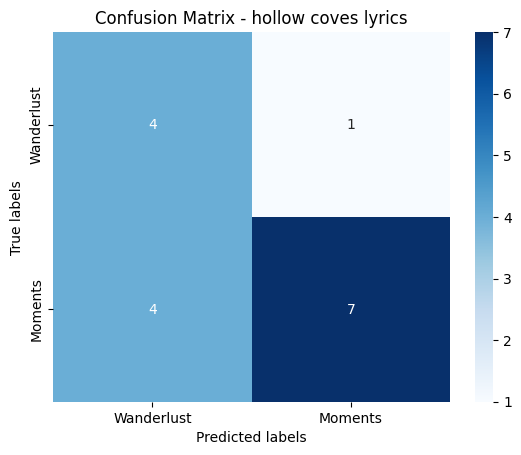

In [28]:
pt.plot_confusion_matrix()

In [29]:
pt.plot_clusters()

In [30]:
pt.plot_sillhouette_score()

This score is between -1 and 1, where 1 means that, in average, the objects are very similar to their own cluster and far from other clusters, and -1 means the opposite.


## Song titles embeddings

In [31]:
pt = Plot(discography, column="song_title")

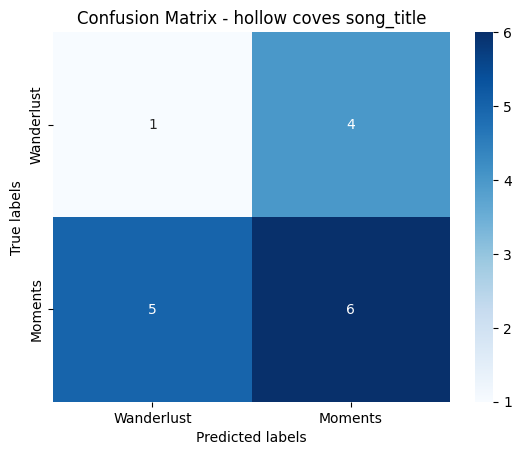

In [32]:
pt.plot_confusion_matrix()

In [33]:
pt.plot_clusters()

In [34]:
pt.plot_sillhouette_score()

This score is between -1 and 1, where 1 means that, in average, the objects are very similar to their own cluster and far from other clusters, and -1 means the opposite.
